In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.datasets import mnist, cifar10
from keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [ ]:
def compress_image_lossy(input_path, quality=50):
    image = cv2.imread(input_path)
    _, compressed = cv2.imencode('.jpeg', image, [int(cv2.IMWRITE_JPEG_QUALITY), quality])
    decompressed = cv2.imdecode(compressed, cv2.IMREAD_COLOR)
    plt.imshow(cv2.cvtColor(decompressed, cv2.COLOR_BGR2RGB))
    plt.title("Lossy Compressed Image")
    plt.axis("off")
    plt.show()

In [ ]:
def compress_image_lossless(input_path):
    image = cv2.imread(input_path)
    _, compressed = cv2.imencode('.png', image, [int(cv2.IMWRITE_PNG_COMPRESSION), 2])
    decompressed = cv2.imdecode(compressed, cv2.IMREAD_COLOR)
    plt.imshow(cv2.cvtColor(decompressed, cv2.COLOR_BGR2RGB))
    plt.title("Lossless Compressed Image")
    plt.axis("off")
    plt.show()

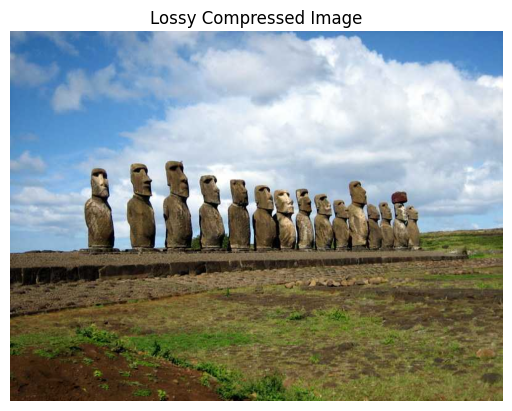

In [ ]:
compress_image_lossy("input.jpeg")

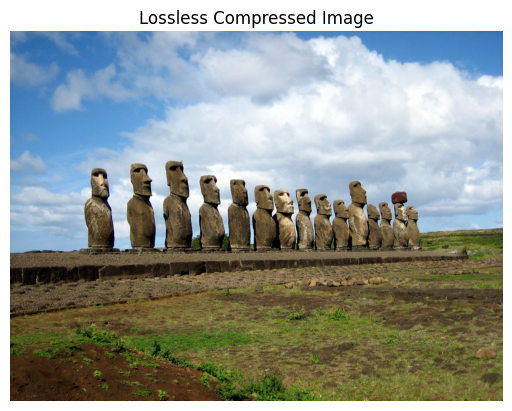

In [ ]:
compress_image_lossless("input.jpeg")

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist, cifar10
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

In [3]:
def load_mnist():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize
    x_train = np.expand_dims(x_train, axis=-1)  # Add channel dimension
    x_test = np.expand_dims(x_test, axis=-1)

    y_train, y_test = to_categorical(y_train, 10), to_categorical(y_test, 10)  # One-hot encode

    # Perform 80-20 train-test split
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

    return x_train, y_train, x_val, y_val, x_test, y_test

def load_cifar10():
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize

    y_train, y_test = to_categorical(y_train, 10), to_categorical(y_test, 10)  # One-hot encode

    # Perform 80-20 train-test split
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

    return x_train, y_train, x_val, y_val, x_test, y_test

In [4]:
def build_cnn(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2,2)),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [5]:
def train_and_evaluate(model, x_train, y_train, x_val, y_val, x_test, y_test, epochs=10):
    history = model.fit(x_train, y_train, epochs=epochs, validation_data=(x_val, y_val), batch_size=64)

    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)

    y_pred_probs = model.predict(x_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)

    report = classification_report(y_true, y_pred, output_dict=True)
    cm = confusion_matrix(y_true, y_pred)

    return history, test_acc, report, cm, y_pred_probs, y_true

In [6]:
def evaluate_metrics(report, cm, y_true, y_pred_probs):
    print("\nClassification Report:")
    for label, metrics in report.items():
        if label.isdigit():  # Only print numeric class labels
            print(f"Class {label}: Precision={metrics['precision']:.4f}, Recall={metrics['recall']:.4f}, F1-score={metrics['f1-score']:.4f}")

    # Confusion Matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    # ROC-AUC for each class
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(10):
        fpr[i], tpr[i], _ = roc_curve(to_categorical(y_true, 10)[:, i], y_pred_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # ROC Curves
    plt.figure(figsize=(8,6))
    for i in range(10):
        plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")
    plt.plot([0,1], [0,1], 'k--')  # Random guess line
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves for Each Class")
    plt.legend()
    plt.show()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 64s 79ms/step - accuracy: 0.8260 - loss: 0.5488 - val_accuracy: 0.9811 - val_loss: 0.0616
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 64s 56ms/step - accuracy: 0.9699 - loss: 0.1000 - val_accuracy: 0.9858 - val_loss: 0.0502
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 84s 58ms/step - accuracy: 0.9797 - loss: 0.0712 - val_accuracy: 0.9883 - val_loss: 0.0377
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 83s 59ms/step - accuracy: 0.9847 - loss: 0.0495 - val_accuracy: 0.9886 - val_loss: 0.0437
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 81s 59ms/step - accuracy: 0.9859 - loss: 0.0454 - val_accuracy: 0.9897 - val_loss: 0.0366
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 46s 61ms/step - accuracy: 0.9886 - loss: 0.0380 - val_accuracy: 0.9905 - val_loss: 0.0323
Epoch 7/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 77s 55ms/step - accuracy: 0.9900 - loss: 0.0329 - val_accuracy: 0.9910 - val_loss: 0.0300
Epoch 8/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 43s 57ms/step - accuracy: 0.9915 - loss: 0.0273 - 

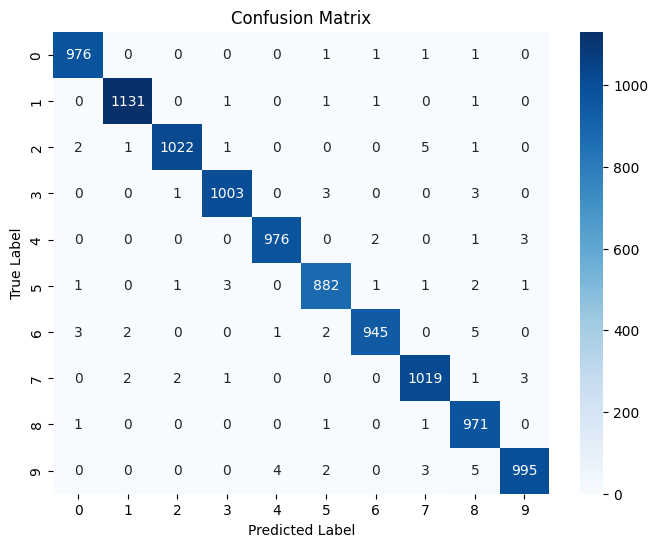

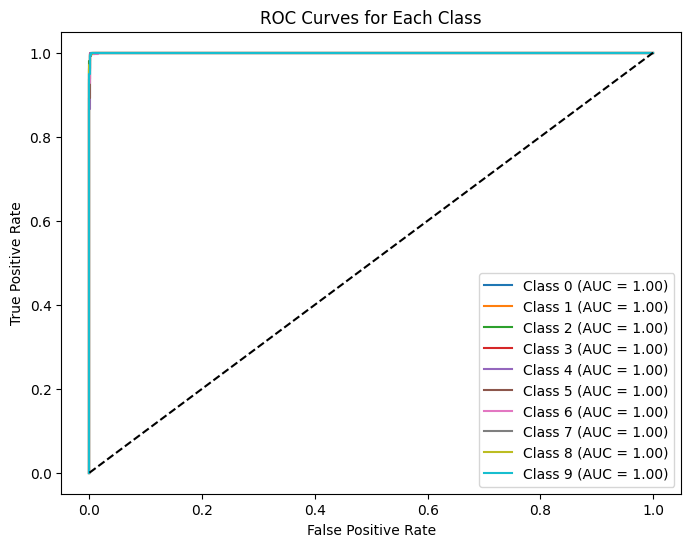

In [7]:
x_train_mnist, y_train_mnist, x_val_mnist, y_val_mnist, x_test_mnist, y_test_mnist = load_mnist()

# Build and Train CNN Model
cnn_mnist = build_cnn(input_shape=(28,28,1), num_classes=10)
history_mnist, test_acc_mnist, report_mnist, cm_mnist, y_pred_probs_mnist, y_true_mnist = train_and_evaluate(
    cnn_mnist, x_train_mnist, y_train_mnist, x_val_mnist, y_val_mnist, x_test_mnist, y_test_mnist, epochs=10
)

# Evaluate MNIST Model
print(f"MNIST Test Accuracy: {test_acc_mnist:.4f}")
evaluate_metrics(report_mnist, cm_mnist, y_true_mnist, y_pred_probs_mnist)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 56s 86ms/step - accuracy: 0.3105 - loss: 1.8657 - val_accuracy: 0.5254 - val_loss: 1.3497
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 79s 82ms/step - accuracy: 0.5060 - loss: 1.3830 - val_accuracy: 0.5953 - val_loss: 1.1522
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 84s 85ms/step - accuracy: 0.5734 - loss: 1.2047 - val_accuracy: 0.6178 - val_loss: 1.0788
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 81s 83ms/step - accuracy: 0.6058 - loss: 1.1259 - val_accuracy: 0.6498 - val_loss: 0.9902
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 51s 81ms/step - accuracy: 0.6329 - loss: 1.0465 - val_accuracy: 0.6662 - val_loss: 0.9642
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 83s 83ms/step - accuracy: 0.6513 - loss: 0.9853 - val_accuracy: 0.6806 - val_loss: 0.9265
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 84s 87ms/step - accuracy: 0.6667 - loss: 0.9453 - val_accuracy: 0.6825 - val_loss: 0.8996
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 79s 81ms/step - accuracy: 0.6858 - loss: 0.8921 - 

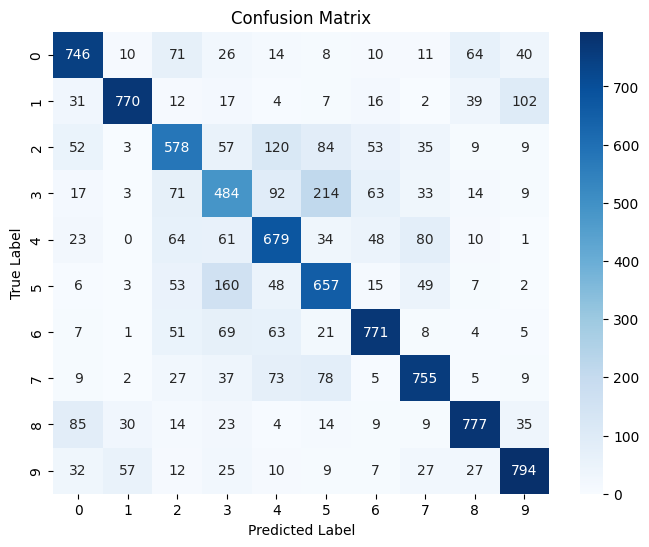

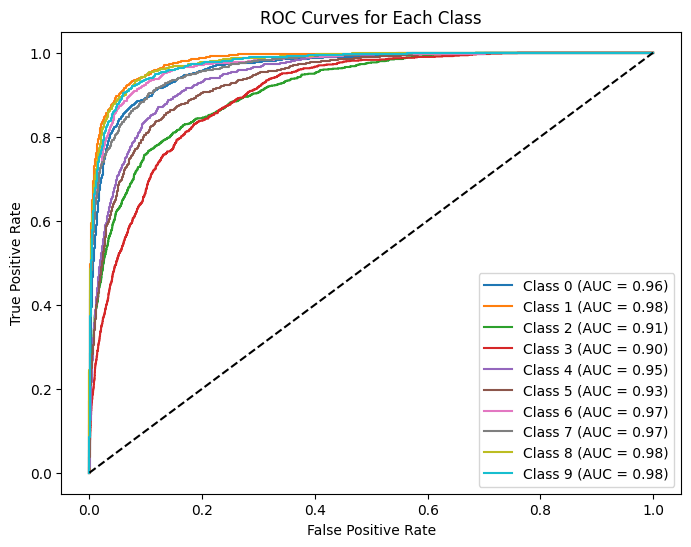

In [8]:
# CIFAR-10 data
x_train_cifar, y_train_cifar, x_val_cifar, y_val_cifar, x_test_cifar, y_test_cifar = load_cifar10()

# Build and Train CNN Model
cnn_cifar = build_cnn(input_shape=(32,32,3), num_classes=10)
history_cifar, test_acc_cifar, report_cifar, cm_cifar, y_pred_probs_cifar, y_true_cifar = train_and_evaluate(
    cnn_cifar, x_train_cifar, y_train_cifar, x_val_cifar, y_val_cifar, x_test_cifar, y_test_cifar, epochs=10
)

# Evaluate CIFAR-10 Model
print(f"CIFAR-10 Test Accuracy: {test_acc_cifar:.4f}")
evaluate_metrics(report_cifar, cm_cifar, y_true_cifar, y_pred_probs_cifar)